# RandomForest Optimization with PSD Features from EEG Data

**Description**:\
After getting the Cross-Validation results, the aim in this notebook will be testing the models with the best results and applying the hyper parameters optimization.

**Author**: Elmo Chavez\
**Date**: October 31, 2023

## Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import sys

# Sklearn Score metrics
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, chi2
# Classifier
from sklearn.ensemble import RandomForestClassifier
# Plot
import matplotlib.pyplot as plt
import seaborn as sns
# EEG Methods
path_eeg_mne = os.path.abspath(os.path.join(os.path.dirname('eeg_mne.py'), '..'))
sys.path.append(path_eeg_mne)
import eeg_mne

## Read the Data

Read Training Datasets

In [2]:
path = '../Training Dataset/'
file_psd_feat_all = 'PSD_Features-All_Channels.csv'
file_psd_feat_fp1 = 'PSD_Features-FP1_Channel.csv'

df_psd_features_all = pd.read_csv(path+file_psd_feat_all)
df_psd_features_fp1 = pd.read_csv(path+file_psd_feat_fp1)

print('PSD Features All Channels shape:', df_psd_features_all.shape)
print('PSD Features FP1 Channel shape:', df_psd_features_fp1.shape)

PSD Features All Channels shape: (44, 6274)
PSD Features FP1 Channel shape: (44, 334)


Read Results from Cross-Validation

In [3]:
file_results = 'Results PSD - Cross-Validation.csv'

df_results_psd_cv = pd.read_csv(path+file_results)
df_results_psd_cv.head()

,Unnamed: 0,feature_extraction,channels,classifier,cross-validation,feature-selection,accuracy,f1_score,AUC
0,0,PSD,All,Support Vector,KFold,anova,0.477778,0.425000,0.471667
1,1,PSD,All,Support Vector,KFold,mutual_info_classif,0.544444,0.451299,0.590000
2,2,PSD,All,Support Vector,KFold,chi2,0.461111,0.369744,0.550000
3,3,PSD,All,Support Vector,StratifiedKFold,anova,0.544444,0.468075,0.565000
4,4,PSD,All,Support Vector,StratifiedKFold,mutual_info_classif,0.566667,0.456667,0.575000


## Quick Explore of the Data

In [4]:
eeg_mne.Dataset_Features_Summary(df_psd_features_all)
df_psd_features_all.head()

Total Features: 6274
Windows: 11 -> ['w0', 'w1', 'w10', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9']
Channels: 19 -> ['T4', 'F7', 'F3', 'C4', 'F8', 'P3', 'C3', 'Pz', 'O2', 'Fp1', 'Fz', 'Cz', 'Fp2', 'O1', 'F4', 'T3', 'T6', 'P4', 'T5']
Frequency Bands: 5 -> ['beta', 'theta', 'gamma', 'alpha', 'delta']
Features: 6 -> ['average power', 'std dev', 'spectral entropy', 'peak to peak', 'total power', 'relative power']


,participant_id,w0_Fp1_delta_total_power,w0_Fp2_delta_total_power,w0_F3_delta_total_power,w0_F4_delta_total_power,w0_C3_delta_total_power,w0_C4_delta_total_power,w0_P3_delta_total_power,w0_P4_delta_total_power,w0_O1_delta_total_power,...,w10_T3_gamma_peak_to_peak,w10_T4_gamma_peak_to_peak,w10_T5_gamma_peak_to_peak,w10_T6_gamma_peak_to_peak,w10_Fz_gamma_peak_to_peak,w10_Cz_gamma_peak_to_peak,w10_Pz_gamma_peak_to_peak,Gender,Age,Group
0,sub-001,1.482606e-10,1.399864e-10,1.315407e-10,1.296565e-10,1.282590e-10,1.303774e-10,1.333272e-10,1.370710e-10,1.435011e-10,...,3.386688e-13,2.955004e-13,5.828301e-13,3.091508e-13,2.907760e-13,2.915964e-13,2.048106e-13,0,57,0
1,sub-002,1.079119e-10,1.114170e-10,1.113520e-10,1.128301e-10,1.113290e-10,1.130439e-10,1.129429e-10,1.143529e-10,1.139642e-10,...,2.484285e-13,2.515664e-13,2.061092e-13,2.073052e-13,1.989391e-13,1.647601e-13,1.809839e-13,0,78,0
2,sub-004,1.405334e-10,1.227932e-10,1.387294e-10,1.335640e-10,1.315632e-10,1.274436e-10,1.349376e-10,1.327209e-10,1.358135e-10,...,4.622522e-13,5.365377e-13,3.226660e-13,3.864883e-13,2.263159e-13,1.842558e-13,2.225526e-13,0,67,0
3,sub-005,1.656372e-10,1.305764e-10,1.400050e-10,1.418274e-10,1.371958e-10,1.362168e-10,1.447223e-10,1.434388e-10,1.424622e-10,...,2.383642e-12,4.735548e-13,4.784333e-13,4.677075e-13,3.885211e-13,2.389231e-13,2.789744e-13,1,70,0
4,sub-006,1.592726e-10,1.492380e-10,1.578813e-10,1.494216e-10,1.517660e-10,1.446006e-10,1.480658e-10,1.489056e-10,1.517877e-10,...,9.004288e-13,3.977423e-13,4.030327e-13,4.308146e-13,3.449713e-13,2.547785e-13,2.279764e-13,0,61,0


In [5]:
eeg_mne.Dataset_Features_Summary(df_psd_features_fp1)
df_psd_features_fp1.head()

Total Features: 334
Windows: 11 -> ['w0', 'w1', 'w10', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9']
Channels: 1 -> ['Fp1']
Frequency Bands: 5 -> ['beta', 'theta', 'gamma', 'alpha', 'delta']
Features: 6 -> ['average power', 'std dev', 'spectral entropy', 'peak to peak', 'total power', 'relative power']


,participant_id,w0_Fp1_delta_total_power,w1_Fp1_delta_total_power,w2_Fp1_delta_total_power,w3_Fp1_delta_total_power,w4_Fp1_delta_total_power,w5_Fp1_delta_total_power,w6_Fp1_delta_total_power,w7_Fp1_delta_total_power,w8_Fp1_delta_total_power,...,w4_Fp1_gamma_peak_to_peak,w5_Fp1_gamma_peak_to_peak,w6_Fp1_gamma_peak_to_peak,w7_Fp1_gamma_peak_to_peak,w8_Fp1_gamma_peak_to_peak,w9_Fp1_gamma_peak_to_peak,w10_Fp1_gamma_peak_to_peak,Gender,Age,Group
0,sub-001,1.482606e-10,1.539664e-10,1.640913e-10,1.277807e-10,1.546334e-10,1.602554e-10,1.522455e-10,1.391906e-10,1.629814e-10,...,7.380106e-13,5.186201e-13,5.164246e-13,4.919865e-13,4.522907e-13,4.652932e-13,5.643991e-13,0,57,0
1,sub-002,1.079119e-10,1.032955e-10,1.220342e-10,1.187597e-10,1.227705e-10,1.210614e-10,1.277992e-10,1.234906e-10,1.256641e-10,...,7.699532e-13,3.676913e-13,2.817223e-13,2.394770e-13,3.544304e-13,2.473381e-13,2.063013e-13,0,78,0
2,sub-004,1.405334e-10,1.819675e-10,1.542677e-10,1.718428e-10,1.167535e-10,1.211645e-10,1.382233e-10,1.551854e-10,1.771741e-10,...,8.399157e-13,8.695519e-13,7.697982e-13,8.206731e-13,6.854909e-13,4.246755e-13,4.607840e-13,0,67,0
3,sub-005,1.656372e-10,1.230197e-10,1.331212e-10,1.666786e-10,1.776709e-10,1.571387e-10,1.633155e-10,1.683460e-10,1.507685e-10,...,1.491440e-12,1.000392e-12,7.040914e-13,7.395305e-13,1.422540e-12,2.014033e-12,1.652614e-12,1,70,0
4,sub-006,1.592726e-10,1.497835e-10,1.307667e-10,1.378685e-10,1.364859e-10,1.274019e-10,1.437636e-10,1.490190e-10,1.466645e-10,...,3.440082e-13,3.092531e-13,3.348430e-13,3.375979e-13,3.341492e-13,4.838252e-13,4.263739e-13,0,61,0


Best AUC

In [6]:
df_results_psd_cv.sort_values('AUC',ascending=False).head()

,Unnamed: 0,feature_extraction,channels,classifier,cross-validation,feature-selection,accuracy,f1_score,AUC
71,71,PSD,Fp1,XGBoost,StratifiedShuffleSplit,chi2,0.733333,0.726450,0.75
26,26,PSD,All,XGBoost,StratifiedShuffleSplit,chi2,0.733333,0.726450,0.75
17,17,PSD,All,Random Forest,StratifiedShuffleSplit,chi2,0.733333,0.725556,0.74
14,14,PSD,All,Random Forest,StratifiedKFold,chi2,0.705556,0.699870,0.72
37,37,PSD,All,AdaBoost,KFold,mutual_info_classif,0.705556,0.701111,0.71


Best Accuracy

In [7]:
df_results_psd_cv.sort_values('accuracy',ascending=False).head()

,Unnamed: 0,feature_extraction,channels,classifier,cross-validation,feature-selection,accuracy,f1_score,AUC
26,26,PSD,All,XGBoost,StratifiedShuffleSplit,chi2,0.733333,0.726450,0.75
71,71,PSD,Fp1,XGBoost,StratifiedShuffleSplit,chi2,0.733333,0.726450,0.75
17,17,PSD,All,Random Forest,StratifiedShuffleSplit,chi2,0.733333,0.725556,0.74
82,82,PSD,Fp1,AdaBoost,KFold,mutual_info_classif,0.705556,0.701111,0.71
14,14,PSD,All,Random Forest,StratifiedKFold,chi2,0.705556,0.699870,0.72


Best F1 Scores

In [8]:
df_results_psd_cv.sort_values('f1_score',ascending=False).head()

,Unnamed: 0,feature_extraction,channels,classifier,cross-validation,feature-selection,accuracy,f1_score,AUC
26,26,PSD,All,XGBoost,StratifiedShuffleSplit,chi2,0.733333,0.726450,0.75
71,71,PSD,Fp1,XGBoost,StratifiedShuffleSplit,chi2,0.733333,0.726450,0.75
17,17,PSD,All,Random Forest,StratifiedShuffleSplit,chi2,0.733333,0.725556,0.74
37,37,PSD,All,AdaBoost,KFold,mutual_info_classif,0.705556,0.701111,0.71
82,82,PSD,Fp1,AdaBoost,KFold,mutual_info_classif,0.705556,0.701111,0.71


## Random Forest Modeling

### All Channels

Simple Prediction

---- Initiating ----
-- Train Test Split --
Train: 30
Test: 14
-- Classification --
-- Scores: --
Accuracy: 35.71 %
F1 Score: 35.38 %
AUC: 35.42 %
-- Feature Importance --
-- Saving results --
-- Finishing Prediction --


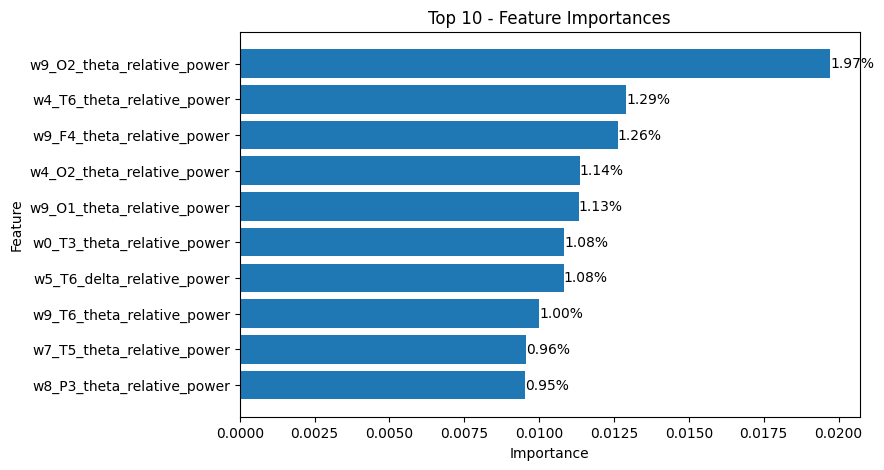

In [9]:
pred_results_all_1 = eeg_mne.get_Classification(df_psd_features_all, 'Random Forest', 
                                         target='Group', key_feature='participant_id', 
                                         test_split=0.30)

Feature Selection with Default K Features

---- Initiating ----
-- Train Test Split --
Train: 30
Test: 14
-- Feature Selection --


-- Classification --
-- Scores: --
Accuracy: 57.14 %
F1 Score: 56.25 %
AUC: 60.42 %
-- Feature Importance --
-- Saving results --
-- Finishing Prediction --


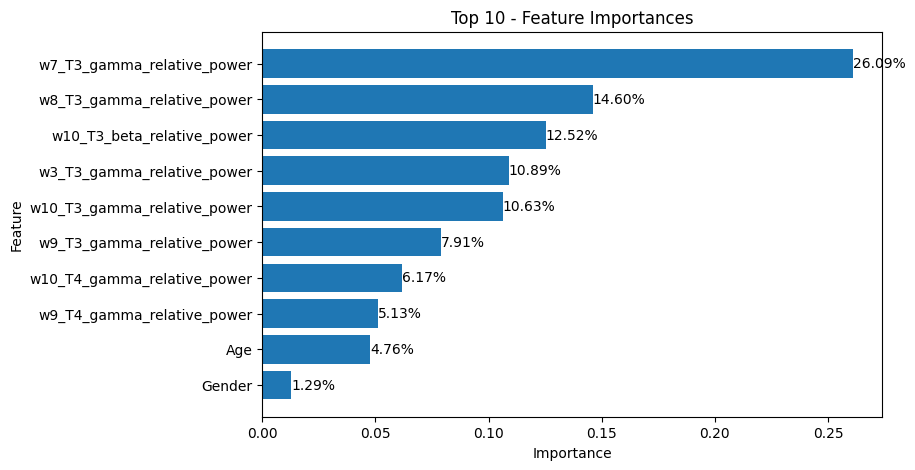

In [10]:
pred_results_all_2 = eeg_mne.get_Classification(df_psd_features_all, 'Random Forest', 
                                         target='Group', key_feature='participant_id', 
                                         test_split=0.30,
                                         feature_selection=True)

Feature Selection and setting up the K Features

---- Initiating ----
-- Train Test Split --
Train: 30
Test: 14
-- Feature Selection --
-- Classification --
-- Scores: --
Accuracy: 50.0 %
F1 Score: 49.74 %
AUC: 52.08 %
-- Feature Importance --
-- Saving results --
-- Finishing Prediction --


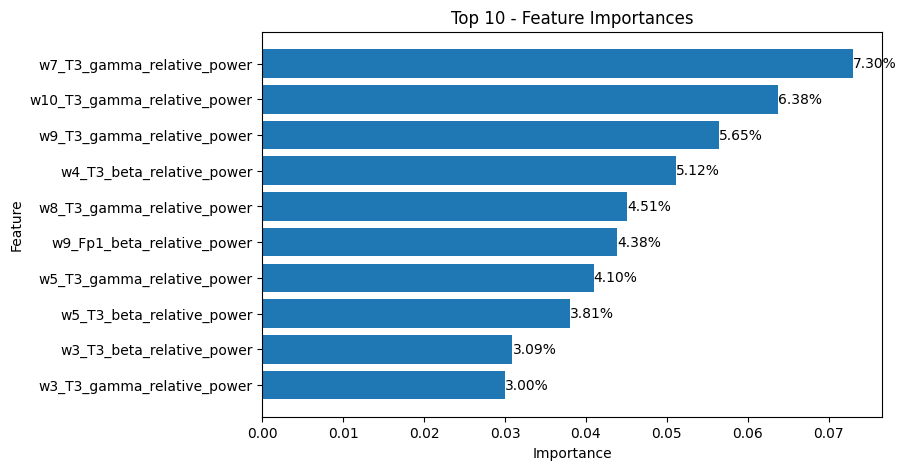

In [11]:
pred_results_all_3 = eeg_mne.get_Classification(df_psd_features_all, 'Random Forest', 
                                         target='Group', key_feature='participant_id', 
                                         test_split=0.30,
                                         feature_selection=True, k_features_selected=50)

### FP1 Channel

Simple Prediction

---- Initiating ----
-- Train Test Split --
Train: 30
Test: 14
-- Classification --
-- Scores: --
Accuracy: 50.0 %
F1 Score: 49.74 %
AUC: 52.08 %
-- Feature Importance --
-- Saving results --
-- Finishing Prediction --


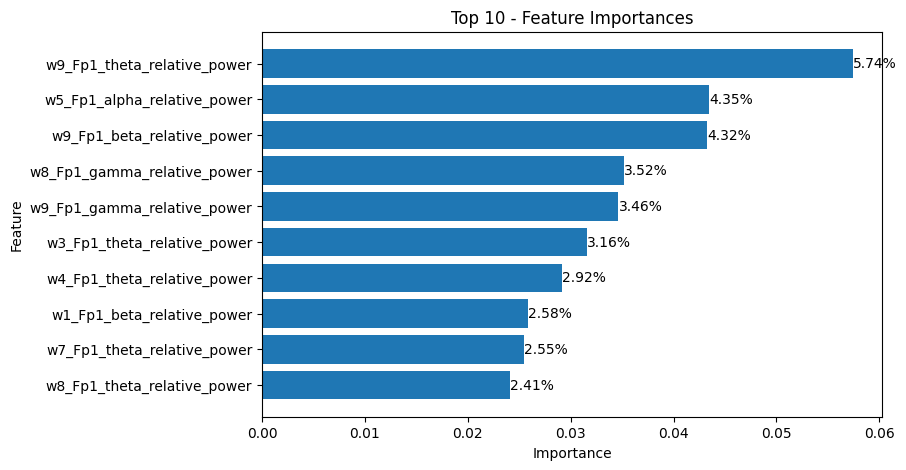

In [12]:
pred_results_fp1_1 = eeg_mne.get_Classification(df_psd_features_fp1, 'Random Forest', 
                                         target='Group', key_feature='participant_id', 
                                         test_split=0.30)

Feature Selection with Default K Features

---- Initiating ----
-- Train Test Split --
Train: 30
Test: 14
-- Feature Selection --
-- Classification --
-- Scores: --
Accuracy: 64.29 %
F1 Score: 62.57 %
AUC: 62.5 %
-- Feature Importance --
-- Saving results --
-- Finishing Prediction --


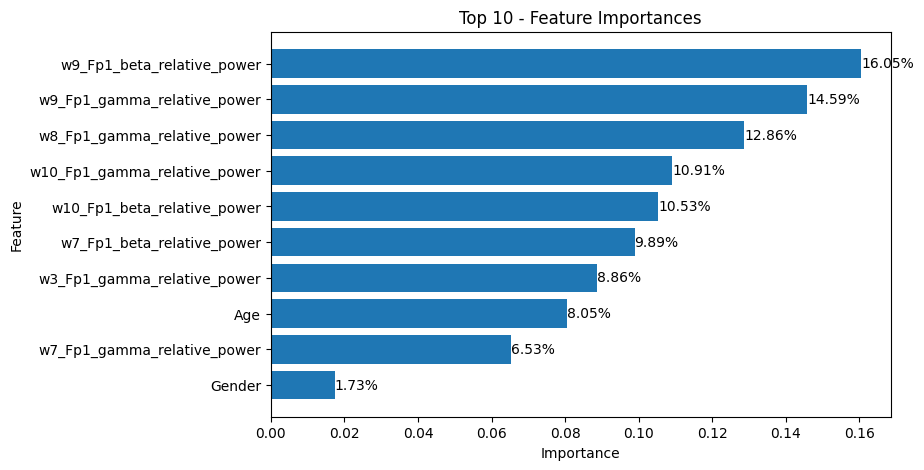

In [13]:
pred_results_fp1_2 = eeg_mne.get_Classification(df_psd_features_fp1, 'Random Forest', 
                                         target='Group', key_feature='participant_id', 
                                         test_split=0.30,
                                         feature_selection=True)

Feature Selection and setting up the K Features

---- Initiating ----
-- Train Test Split --
Train: 30
Test: 14
-- Feature Selection --
-- Classification --
-- Scores: --
Accuracy: 50.0 %
F1 Score: 49.74 %
AUC: 52.08 %
-- Feature Importance --
-- Saving results --
-- Finishing Prediction --


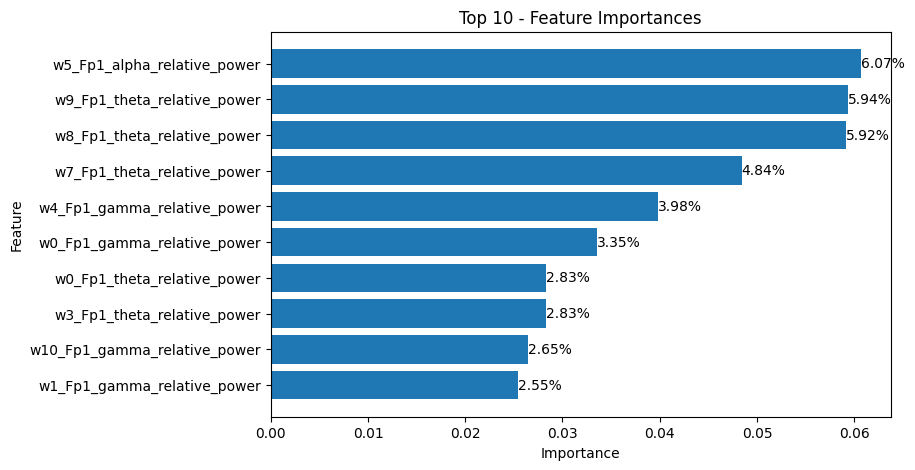

In [14]:
pred_results_fp1_3 = eeg_mne.get_Classification(df_psd_features_fp1, 'Random Forest', 
                                         target='Group', key_feature='participant_id', 
                                         test_split=0.30,
                                         feature_selection=True, k_features_selected=50)

## Hyperparameters Optimization

### All Channels

Random Forest Parameters

In [15]:
# Define a grid of hyperparameters to search for Random Forest
set_params = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [1, 2, 4]
    #'max_features': ['auto', 'sqrt'],
}

Simple Prediction Optimized

---- Initiating ----
-- Train Test Split --
Train: 30
Test: 14
-- Classification --
-- Getting Best Parameters --
-- Scores: --
Accuracy: 35.71 %
F1 Score: 35.38 %
AUC: 37.5 %
-- Feature Importance --
-- Saving results --
-- Finishing Prediction --


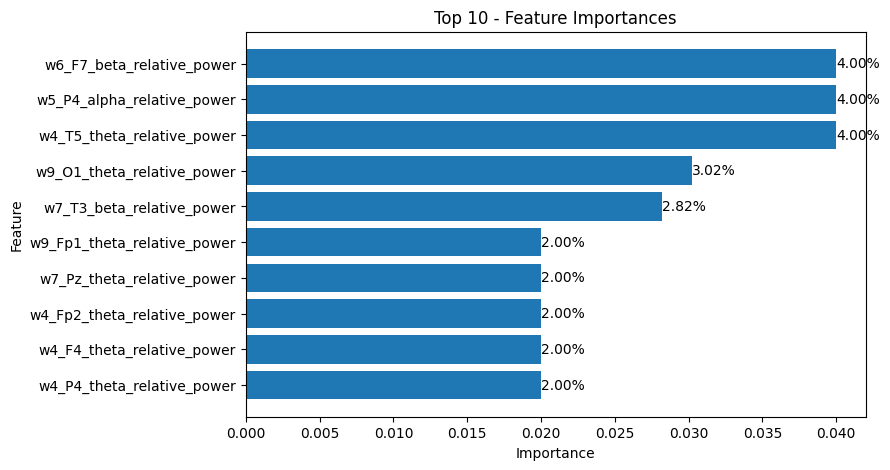

In [16]:
pred_results_all_1_opt = eeg_mne.get_Classification(df_psd_features_all, 'Random Forest', 
                                         target='Group', key_feature='participant_id', 
                                         test_split=0.30,
                                         params=set_params)

Feature Selection with Default K Features

---- Initiating ----
-- Train Test Split --
Train: 30
Test: 14
-- Feature Selection --
-- Classification --
-- Getting Best Parameters --
-- Scores: --
Accuracy: 50.0 %
F1 Score: 49.74 %
AUC: 52.08 %
-- Feature Importance --
-- Saving results --
-- Finishing Prediction --


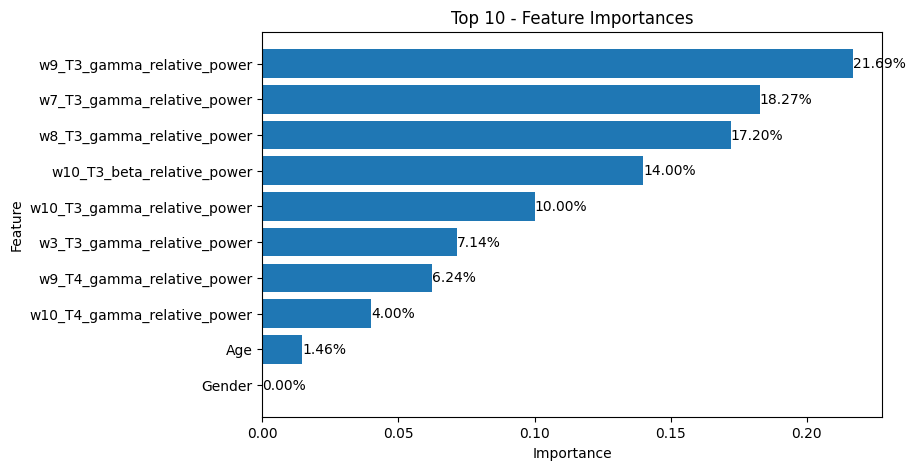

In [17]:
pred_results_all_2_opt = eeg_mne.get_Classification(df_psd_features_all, 'Random Forest', 
                                         target='Group', key_feature='participant_id', 
                                         test_split=0.30,
                                         feature_selection=True,
                                         params=set_params)

Feature Selection and setting up the K Features

---- Initiating ----
-- Train Test Split --
Train: 30
Test: 14
-- Feature Selection --
-- Classification --
-- Getting Best Parameters --
-- Scores: --
Accuracy: 50.0 %
F1 Score: 49.74 %
AUC: 52.08 %
-- Feature Importance --
-- Saving results --
-- Finishing Prediction --


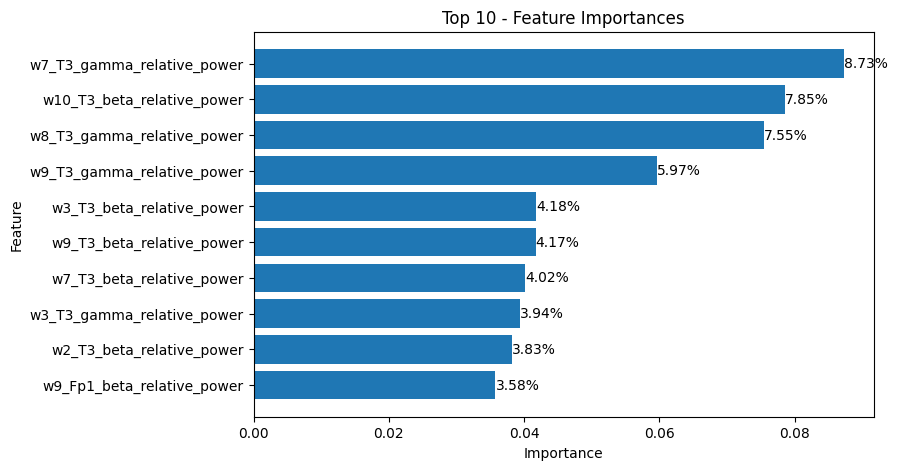

In [18]:
pred_results_all_3_opt = eeg_mne.get_Classification(df_psd_features_all, 'Random Forest', 
                                         target='Group', key_feature='participant_id', 
                                         test_split=0.30,
                                         feature_selection=True, k_features_selected=50,
                                         params=set_params)

### FP1 Channel

Simple Prediction

---- Initiating ----
-- Train Test Split --
Train: 30
Test: 14
-- Classification --
-- Getting Best Parameters --
-- Scores: --
Accuracy: 71.43 %
F1 Score: 71.43 %
AUC: 72.92 %
-- Feature Importance --
-- Saving results --
-- Finishing Prediction --


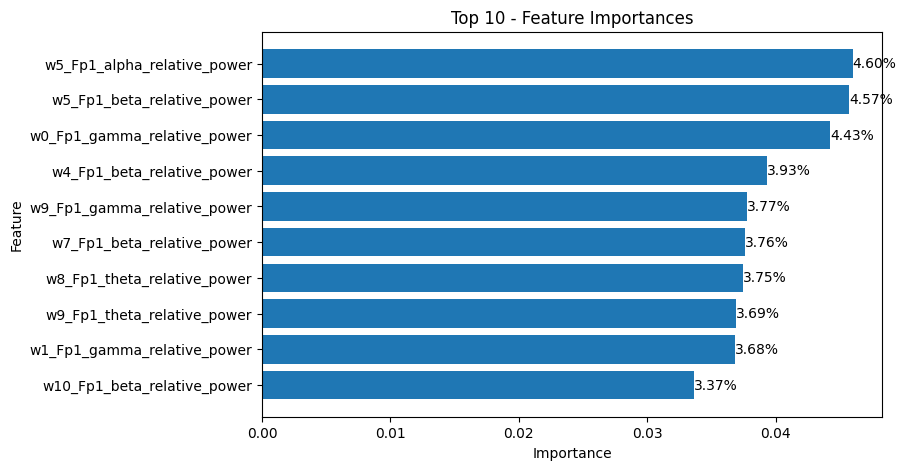

In [19]:
pred_results_fp1_1_opt = eeg_mne.get_Classification(df_psd_features_fp1, 'Random Forest', 
                                         target='Group', key_feature='participant_id', 
                                         test_split=0.30,
                                         params=set_params)

Feature Selection with Default K Features

---- Initiating ----
-- Train Test Split --
Train: 30
Test: 14
-- Feature Selection --
-- Classification --
-- Getting Best Parameters --
-- Scores: --
Accuracy: 64.29 %
F1 Score: 62.57 %
AUC: 62.5 %
-- Feature Importance --
-- Saving results --
-- Finishing Prediction --


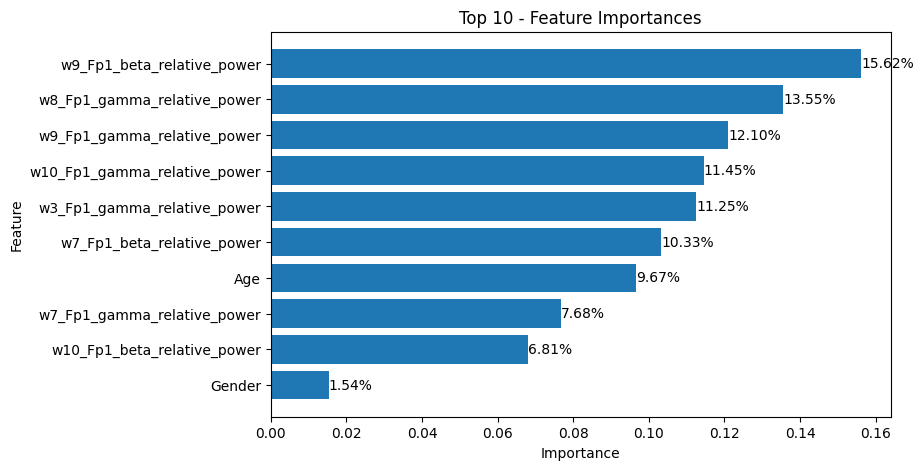

In [20]:
pred_results_fp1_2_opt = eeg_mne.get_Classification(df_psd_features_fp1, 'Random Forest', 
                                         target='Group', key_feature='participant_id', 
                                         test_split=0.30,
                                         feature_selection=True,
                                         params=set_params)

Feature Selection and setting up the K Features

---- Initiating ----
-- Train Test Split --
Train: 30
Test: 14
-- Feature Selection --
-- Classification --
-- Getting Best Parameters --
-- Scores: --
Accuracy: 64.29 %
F1 Score: 64.1 %
AUC: 66.67 %
-- Feature Importance --
-- Saving results --
-- Finishing Prediction --


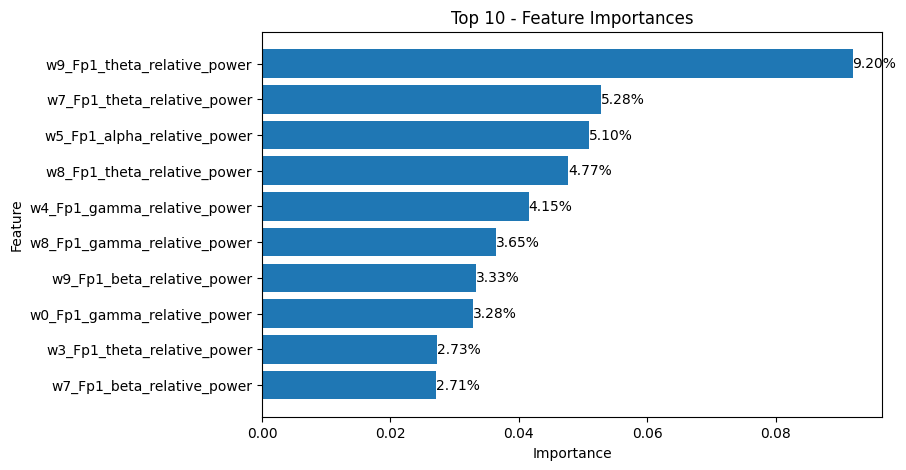

In [21]:
pred_results_fp1_2_opt = eeg_mne.get_Classification(df_psd_features_fp1, 'Random Forest', 
                                         target='Group', key_feature='participant_id', 
                                         test_split=0.30,
                                         feature_selection=True, k_features_selected=50,
                                         params=set_params)